In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(0)


blue = '#0073B7'
yellow = '#FFD23F'
gray = '#7A7A7A'
purple = '#B05AA3'
green = '#00A651'
orange = '#F7941D'


blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow", ["#0073B7", "#FFD23F"]
)


gray = '#C0C0C0'
purple = '#B05AA3'

gray_purple = LinearSegmentedColormap.from_list(
    "gray_purple",
    [gray , purple]
)


import os
import multiprocessing


os.environ["OMP_NUM_THREADS"]="1"
os.environ["MKL_NUM_THREADS"]="1"
os.environ["OPENBLAS_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["MKL_DYNAMIC"]="FALSE"
torch.set_num_threads(1)
torch.set_num_interop_threads(1)
multiprocessing.set_start_method("fork")

In [2]:
from src.model import SSCNetwork
from Network_Definition.forward import forward
from Network_Definition.sleep import sleep
from Network_Definition.parameters import network_parameters
from src.utils.general import make_input, LatentSpace, get_ordered_indices, test_network, get_latent_accuracy, get_sample_from_num_swaps, get_cos_sim_torch, get_signal_to_noise_ratio

from src.utils.Figure_4 import figure4_accuracy

In [3]:
network_parameters["sleep_duration"] = 5000

network_parameters["hidden_num_subregions"] = 2
network_parameters["hidden_size_subregions"] = torch.tensor([50, 50])
network_parameters["hidden_sparsity"] = torch.tensor([10/50, 10/50])
network_parameters["hidden_sparsity_sleep"] = torch.tensor([10/50, 10/50])

network_parameters["frozen"] = False

network_parameters["hidden_hidden_lmbda"] = 5e-5


network_model = {}
network_model["forward"] = forward
network_model["sleep"] = sleep

recording_parameters = {}
recording_parameters["regions"] = ["hidden", "output_hat", "output"]
recording_parameters["rate_activity"] = 1
recording_parameters["connections"] = ["output_hidden"]
recording_parameters["rate_connectivity"] = 1



input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 25000
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

In [4]:
input, input_episodes, input_latents = make_input(**input_params)
network = SSCNetwork(network_parameters, recording_parameters, network_model)

In [5]:
print_rate = 50
with torch.no_grad():
    for day in range(input_params["num_days"]):
        if day%print_rate == 0:
            print(day)
        network(input[day], debug=False)

network.sleep()

output_hidden = np.array(network.connectivity_recordings["output_hidden"])

0


In [6]:
def get_replayed_index(replayed, prototpyes):
    cos_sims = [get_cos_sim_torch(replayed, prototype) for prototype in prototpyes]
    max_sim = torch.argmax(torch.stack(cos_sims, dim=0))
    return max_sim.item()


prototypes = list(input_params["latent_space"].label_to_neurons.values())

replayed_prototypes = torch.tensor([get_replayed_index(x, prototypes) for x in torch.stack(network.activity_recordings["hidden"], axis=0)[network.sleep_indices]])

In [7]:
prototype_0 = replayed_prototypes[0]
prototype_0_indices = torch.where(replayed_prototypes == prototype_0)[0]
prototype_other_indices = torch.where(replayed_prototypes != prototype_0)[0]

A_0, B_0 = input_params["latent_space"].index_to_label[prototype_0]

overlapping_label = (A_0, B_0 + 1)


overlapping_index = input_params["latent_space"].label_to_index[overlapping_label]

prototype_overlapping = torch.where(replayed_prototypes == overlapping_index)[0]

In [8]:
X_hidden_0 = torch.stack(network.activity_recordings["hidden"], axis=0)[network.sleep_indices][0]
X_output_hat_0 = torch.stack(network.activity_recordings["output_hat"], axis=0)[network.sleep_indices][0]
X_output_0 = torch.stack(network.activity_recordings["output"], axis=0)[network.sleep_indices][0]


X_hidden_0_prime = torch.stack(network.activity_recordings["hidden"], axis=0)[network.sleep_indices][prototype_0_indices[1]]
X_output_hat_0_prime = torch.stack(network.activity_recordings["output_hat"], axis=0)[network.sleep_indices][prototype_0_indices[1]]
X_output_0_prime = torch.stack(network.activity_recordings["output"], axis=0)[network.sleep_indices][prototype_0_indices[1]]

X_hidden_1 = torch.stack(network.activity_recordings["hidden"], axis=0)[network.sleep_indices][prototype_other_indices[0]]
X_output_hat_1 = torch.stack(network.activity_recordings["output_hat"], axis=0)[network.sleep_indices][prototype_other_indices[0]]
X_output_1 = torch.stack(network.activity_recordings["output"], axis=0)[network.sleep_indices][prototype_other_indices[0]]

X_hidden_overlapping = torch.stack(network.activity_recordings["hidden"], axis=0)[network.sleep_indices][prototype_overlapping[0]]
X_output_hat_overlapping = torch.stack(network.activity_recordings["output_hat"], axis=0)[network.sleep_indices][prototype_overlapping[0]]
X_output_overlapping = torch.stack(network.activity_recordings["output"], axis=0)[network.sleep_indices][prototype_overlapping[0]]

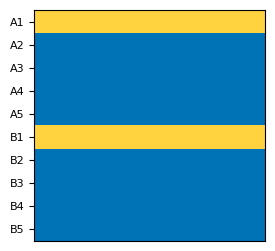

In [9]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(X_hidden_0.reshape((-1, 10)), cmap=blue_yellow, vmin=0, vmax=1) 

# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=8)
plt.xticks([])

plt.savefig("Figures/SVG/4B1.svg", dpi=300, transparent=True)

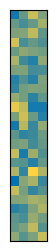

In [10]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(X_output_hat_0.reshape((-1, 4)), cmap=blue_yellow) 
plt.yticks([])
plt.xticks([])
plt.savefig("Figures/SVG/4B2.svg", dpi=300, transparent=True)

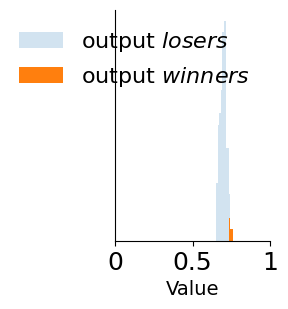

In [11]:

fig = plt.figure(figsize=(2, 3))

output_winners = torch.topk(X_output_hat_0, 4)[0]
output_losers = torch.topk(X_output_hat_0, 100)[0][4:]

bin_size = 0.01  # tamaño de bin fijo


data_min = min(output_losers.min(), output_winners.min())
data_max = max(output_losers.max(), output_winners.max())


bins = np.arange(data_min, data_max + bin_size, bin_size)

plt.hist(output_losers, bins=bins, alpha=0.2, label=r"output $\it{losers}$", color="C0")
plt.hist(output_winners, bins=bins, alpha=1, label=r"output $\it{winners}$", color="C1")

plt.xticks([0, 0.5, 1], [0, 0.5, 1], fontsize=18)
plt.yticks([])

plt.xlabel("Value", fontsize=14)
plt.legend(fontsize=16, frameon=False)
sns.despine()

plt.savefig("Figures/SVG/4B3.svg", dpi=300, transparent=True)

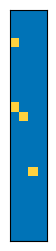

In [12]:
fig = plt.figure(figsize=(3, 3))


plt.imshow(X_output_0.reshape((-1, 4)), cmap=blue_yellow, vmin=0, vmax=1) 
plt.yticks([])
plt.xticks([])

plt.savefig("Figures/SVG/4B4.svg", dpi=300, transparent=True)

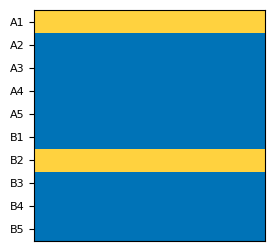

In [13]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(X_hidden_overlapping.reshape((-1, 10)), cmap=blue_yellow, vmin=0, vmax=1) 

# Example parameters
N = 10 # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=8)
plt.xticks([])

plt.savefig("Figures/SVG/4C1.svg", dpi=300, transparent=True)

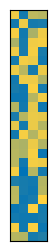

In [14]:
fig = plt.figure(figsize=(3, 3))

plt.imshow(X_output_hat_overlapping.reshape((-1, 4)), cmap=blue_yellow) 
plt.yticks([])
plt.xticks([])

plt.savefig("Figures/SVG/4C2.svg", dpi=300, transparent=True)

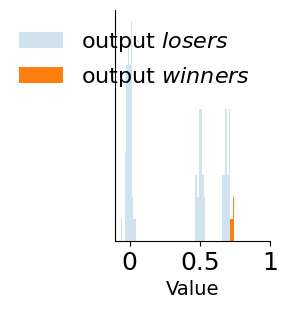

In [15]:

fig = plt.figure(figsize=(2, 3))

output_winners = torch.topk(X_output_hat_overlapping, 4)[0]
output_losers = torch.topk(X_output_hat_overlapping, 100)[0][4:]

bin_size = 0.01  # tamaño de bin fijo


data_min = min(output_losers.min(), output_winners.min())
data_max = max(output_losers.max(), output_winners.max())


bins = np.arange(data_min, data_max + bin_size, bin_size)

plt.hist(output_losers, bins=bins, alpha=0.2, label=r"output $\it{losers}$", color="C0")
plt.hist(output_winners, bins=bins, alpha=1, label=r"output $\it{winners}$", color="C1")

plt.xticks([0, 0.5, 1], [0, 0.5, 1], fontsize=18)
plt.yticks([])

plt.xlabel("Value", fontsize=14)
plt.legend(fontsize=16, frameon=False)
sns.despine()

plt.savefig("Figures/SVG/4C3.svg", dpi=300, transparent=True)

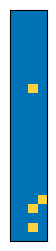

In [16]:
fig = plt.figure(figsize=(3, 3))


plt.imshow(X_output_overlapping.reshape((-1, 4)), cmap=blue_yellow, vmin=0, vmax=1) 
plt.yticks([])
plt.xticks([])

plt.savefig("Figures/SVG/4C4.svg", dpi=300, transparent=True)

In [17]:

input_params = {}
input_params["num_days"] = 200
input_params["day_length"] = 40
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4
input_params["latent_space"] = LatentSpace(**latent_specs)

network.init_recordings(recording_parameters)
network.frozen = False
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf

input, input_episodes, input_latents = make_input(**input_params)

print_rate = 50
with torch.no_grad():
    for day in range(input_params["num_days"]):
        if day%print_rate == 0:
            print(day)
        network(input[day], debug=False)

0
50
100
150


In [18]:
X_output = torch.stack(network.activity_recordings["output"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)
X_episodes = F.one_hot(input_episodes[-100:].long(), num_classes=np.prod(latent_specs["dims"]))

network.selectivity_output_episodes, network.ordered_indices_output_episodes = get_ordered_indices(X_output, X_episodes, assembly_size=4)


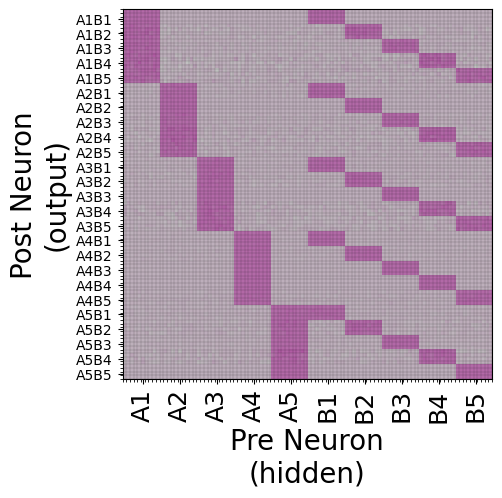

In [19]:
plt.imshow(network.output_hidden[network.ordered_indices_output_episodes], cmap=gray_purple)

plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.xticks(positions, labels,  fontsize=18, rotation=90)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [M * (k + 0.5) for k in range(NA * NB)]

plt.yticks(positions_episodes, labels_episodes)
plt.ylabel("Post Neuron\n(output)", fontsize=20)
plt.xlabel("Pre Neuron\n(hidden)", fontsize=20)
plt.savefig('Figures/SVG/4D.svg', dpi=300, transparent=True)


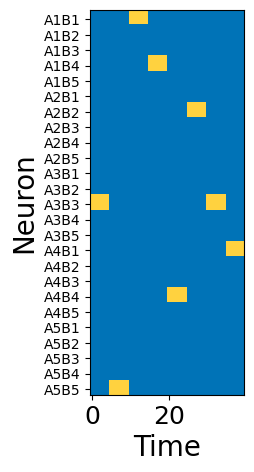

In [20]:
fig = plt.figure(figsize=(5, 5))

plt.imshow(torch.stack(network.activity_recordings["output"], dim=0)[network.awake_indices][-40:, network.ordered_indices_output_episodes].reshape(-1, 100).T, cmap=blue_yellow, vmin=0, vmax=1) 


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes =  [M * (k + 0.5) for k in range(NA * NB)]

plt.xticks([0, 20], fontsize=18)
plt.yticks(positions_episodes, labels_episodes, fontsize=10)

plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)

plt.savefig("Figures/SVG/4E.svg", dpi=300, transparent=True)

In [27]:
num_cpu = 8
num_swaps_train_list = np.arange(0, 18, 2)
num_swaps_test_list = np.arange(0, 18, 2)
snr_list = [get_signal_to_noise_ratio(num_swaps, network.hidden_size*network.hidden_sparsity[0], network.hidden_size, ) for num_swaps in num_swaps_train_list]
num_seeds = 1
seeds = np.arange(num_seeds)
seeds = [int(s) for s in np.asarray(seeds).ravel().tolist()]

In [30]:
num_swaps_train_list

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16])

In [28]:
snr_list

[tensor(inf),
 tensor(3.5000),
 tensor(1.5000),
 tensor(0.8333),
 tensor(0.5000),
 tensor(0.3000),
 tensor(0.1667),
 tensor(0.0714),
 tensor(0.)]

In [63]:
experiment_params = [(network_parameters, network_model, recording_parameters, input_params, latent_specs, num_swaps_train, num_swaps_test, seed) for num_swaps_train in num_swaps_train_list for num_swaps_test in num_swaps_test_list for seed in seeds]
pool = multiprocessing.Pool(processes=num_cpu)

results = np.array(pool.starmap(figure4_accuracy, experiment_params))

0
0
0
00

0
0
0
50
50
50
50
5050

50
50
0
0
0
0
0
0
0
0
50
50
50
5050

50
50
50
0
0
0
0
0
00

0
50
50
50
50
50
50
50
50
0
0
0
0
0
0
0
0
50
5050

50
50
50
50
50
0
0
0
0
0
0
0
0
50
50
50
50
50
50
50
50
0
0
0
0
0
0
0
0
50
50
50
50
50
50
50
50
0
0
0
0
0
0
0
0
50
50
50
50
50
50
50
50
00

0
0
0
0
0
0
50
50
50
50
50
50
50
50
0
0
0
0
0
00

0
50
50
50
50
50
50
50
50
0
0
0
50
50
50
0
0
0
50
50
50
0
0
0
50
5050



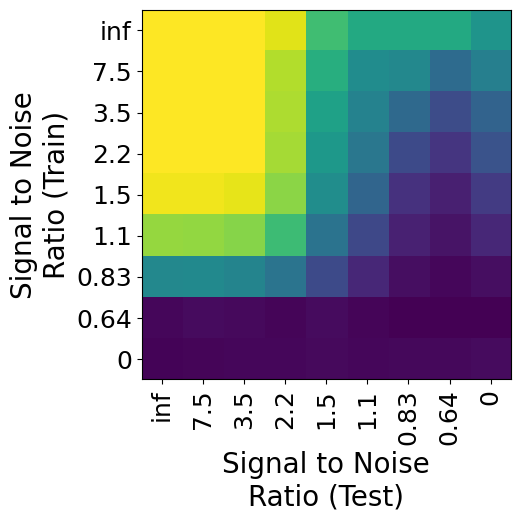

In [69]:
snr_labels = [f"{x:.2g}" for x in snr_list]

plt.imshow(results.mean(axis=1).reshape(len(snr_list), len(snr_list)).T)

plt.ylabel("Signal to Noise\nRatio (Train)", fontsize=20)
plt.xlabel("Signal to Noise\nRatio (Test)", fontsize=20)
plt.xticks(np.arange(len(snr_labels)), snr_labels, fontsize=18, rotation=90)
plt.yticks(np.arange(len(snr_labels)), snr_labels, fontsize=18)
plt.savefig("Figures/SVG/4E.svg", dpi=300, transparent=True)